In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the data
file_path = "SPY_section_1.csv"
df = pd.read_csv(file_path)

In [4]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# Define LSTM model
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out
    
    
sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [6]:
# Define the target variable
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)
df = df.dropna()

In [7]:
# Adding SMA and EMA to the feature
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean() # Short-term SMA
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean() # Medium-term SMA
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean() # Long-term SMA

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [8]:
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]

train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(X_scaled.shape)

Train: 1420, Val: 304, Test: 295
(2029, 11)


In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<span style="color: yellow; font-size: 40px;">Evaluating original LSTM</span>

In [10]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30

C:\Users\ROG\AppData\Local\Temp/ipykernel_29944/786060412.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LSTM_model.load_state_dict(torch.load(LSTM_model_path))
d:\Anac


===== Evaluation Results =====
Test Loss: 36.7081
Test MAE: 4.6086
Average Error Percentage: 4.13%
Largest Error Percentage: 13.03%


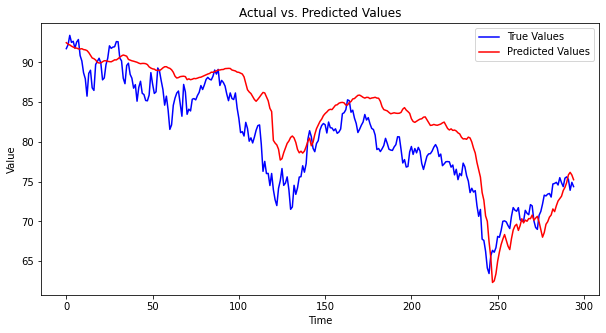

In [11]:
# Define paths
LSTM_model_path = "./lstm_codes/lstm_models/lstm_section_1.pth"  # Change this to your specific model file

# Load the trained model
LSTM_model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
LSTM_model.load_state_dict(torch.load(LSTM_model_path))
LSTM_model.eval()

# Define loss function
criterion = torch.nn.MSELoss()

# Evaluate on test data
test_loss = 0.0
test_mae = 0.0
all_true = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = LSTM_model(X_batch)
        loss = criterion(outputs, y_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        
        test_loss += loss.item() * X_batch.size(0)
        test_mae += mae.item() * X_batch.size(0)
        
        all_true.extend(y_batch.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Compute final metrics
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

# Compute error percentages
all_true = np.array(all_true).flatten()
all_preds = np.array(all_preds).flatten()
error = np.abs(all_true - all_preds) / (np.abs(all_true) + 1e-8)
avg_error = np.mean(error) * 100
largest_error = np.max(error) * 100

# Print results
print("\n===== Evaluation Results =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Average Error Percentage: {avg_error:.2f}%")
print(f"Largest Error Percentage: {largest_error:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='True Values', color='blue')
plt.plot(all_preds, label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


<span style="color: yellow; font-size: 40px;">Evaluating original autoencoder</span>

In [12]:
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

In [13]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [14]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [15]:
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

In [16]:
autoencoder_model_path = "./autoencoder_codes/autoencoder_models/autoencoder_section_1.pth"
autoencoder_model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate).to(device)
autoencoder_model.load_state_dict(torch.load(autoencoder_model_path))

C:\Users\ROG\AppData\Local\Temp/ipykernel_29944/1628310557.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(autoencoder_model

<All keys matched successfully>

In [17]:
autoencoder_model.eval()
with torch.no_grad():
    reconstructed_test = autoencoder_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
mse = np.mean((X_test - reconstructed_test) ** 2)
mae = np.mean(np.abs(X_test - reconstructed_test))
ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
average_error = np.mean(reconstruction_error_percentage)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}, Average Error: {average_error:.4f}%')

MSE: 0.0016, MAE: 0.0273, REE: 0.0377, Euclidean Distance: 0.1188, Average Error: 2.8993%


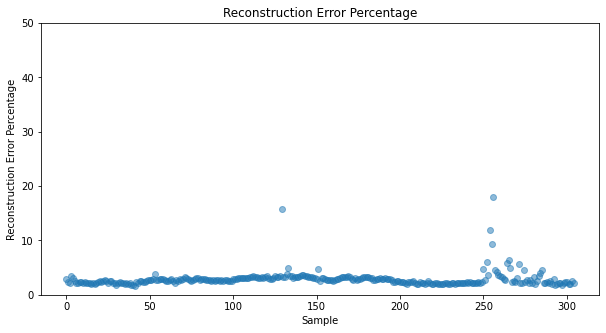

In [18]:
# Scatter plot of reconstruction error percentage
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, alpha=0.5)
plt.ylim(0, 50)
plt.xlabel('Sample')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage')
plt.show()


<span style="color: yellow; font-size: 40px;">Bias correction model - single input</span>

In [19]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size1, dropout_rate):
#         super(BiasPredictor, self).__init__()
        
#         hidden_size2 = hidden_size1 // 2
#         hidden_size3 = hidden_size2 // 2
#         hidden_size4 = hidden_size3 // 2  # New additional layer

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.dropout1 = nn.Dropout(dropout_rate)
        
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)
        
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # New additional layer
#         self.dropout4 = nn.Dropout(dropout_rate)

#         self.fc5 = nn.Linear(hidden_size4, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
        
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)
        
#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         x = F.relu(self.fc4(x))  # New layer
#         x = self.dropout4(x)

#         return self.fc5(x)



import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        hidden_size2 = hidden_size // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 1) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.fc3(x)

In [20]:
# Get LSTM predictions of entire dataset
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
    LSTM_preds = LSTM_model(X_tensor).cpu().numpy()
    
# Put LSTM predictions into a new DataFrame
new_df = pd.DataFrame(LSTM_preds, columns=["LSTM_Pred"])


In [21]:
# Drop the first sequence_length rows
temp_y = y
temp_y = temp_y[sequence_length:]

# add the target variable to the new DataFrame
new_df["Target"] = temp_y.values

In [22]:
# Get reconstruction error percentage for the entire dataset
autoencoder_model.eval()
with torch.no_grad():
    reconstructed = autoencoder_model(torch.tensor(X_scaled.values, dtype=torch.float32).to(device)).cpu().numpy()
    
# Compute the MAE
reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed), axis=1)

# Compute the reconstruction error percentage
# reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed) / (np.abs(X_scaled.values) + 1e-8), axis=1) * 100
# reconstruction_error = np.mean((X_scaled.values - reconstructed) / ((X_scaled.values) + 1e-8), axis=1) * 100

# Drop the first sequence_length rows
reconstruction_error_new = reconstruction_error[sequence_length:]

# Add the reconstruction error to the new DataFrame
new_df["Reconstruction_error_single"] = reconstruction_error_new

# Get reconstruction error arr of past 10 days
reconstruction_error_arr = []
for i in range(sequence_length, len(reconstruction_error)):
    reconstruction_error_arr.append(reconstruction_error[i - sequence_length:i])
    

# Add the reconstruction error array to the new DataFrame
new_df["Reconstruction_error_arr"] = reconstruction_error_arr



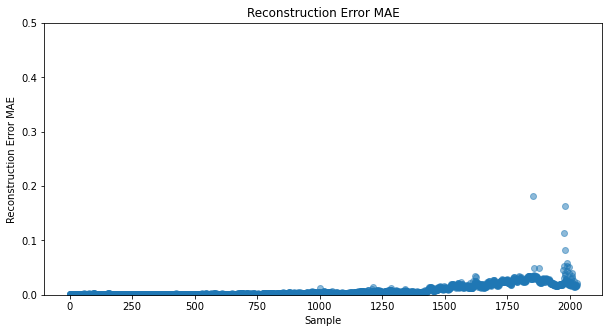

In [23]:
# plot reconstruction error scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, alpha=0.5)
plt.ylim(0, 0.5)
plt.xlabel('Sample')
# plt.ylabel('Reconstruction Error Percentage')
# plt.title('Reconstruction Error Percentage')
plt.ylabel('Reconstruction Error MAE')
plt.title('Reconstruction Error MAE')
plt.show()


In [24]:
reconstruction_error_arr[0]

array([0.00189878, 0.00180705, 0.00187238, 0.00172222, 0.00195921,
       0.00198496, 0.00210326, 0.00231762, 0.00201488, 0.00175625])

In [25]:
# Calculate the difference between the target and LSTM prediction
new_df["Bias"] = new_df["Target"] - new_df["LSTM_Pred"]

In [26]:
y = new_df["Bias"]
X = new_df["Reconstruction_error_single"]
# X = new_df["Reconstruction_error_arr"]

In [27]:
# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Scale using StandardScaler (fit only on train data)
# X_scaler = StandardScaler()
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw.values.reshape(-1, 1))
X_val_scaled = X_scaler.transform(X_val_raw.values.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test_raw.values.reshape(-1, 1))

# y_scaler = StandardScaler()
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val_raw.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1413, Val: 302, Test: 304


In [28]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define model
input_size = 1
hidden_size = 32
dropout_rate = 0.0
learning_rate = 0.0001
num_epochs = 500
patience = 20

bias_model = BiasPredictor(input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

# Train the model (don't need to save the model yet)
best_val_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    bias_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = bias_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        
    train_loss /= len(train_loader.dataset)
    
    bias_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = bias_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        
    val_loss /= len(val_loader.dataset)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    elif epoch - best_epoch >= patience:
        print(f"Stopping early at epoch {epoch}")
        break
    
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        

        

Epoch 0, Train Loss: 0.8302, Val Loss: 6.0114
Epoch 1, Train Loss: 0.8068, Val Loss: 6.5131
Epoch 2, Train Loss: 0.7898, Val Loss: 7.0580
Epoch 3, Train Loss: 0.7747, Val Loss: 7.6339
Epoch 4, Train Loss: 0.7613, Val Loss: 8.2175
Epoch 5, Train Loss: 0.7495, Val Loss: 8.8671
Epoch 6, Train Loss: 0.7395, Val Loss: 9.5940
Epoch 7, Train Loss: 0.7330, Val Loss: 10.1313
Epoch 8, Train Loss: 0.7282, Val Loss: 10.6925
Epoch 9, Train Loss: 0.7248, Val Loss: 11.1775
Epoch 10, Train Loss: 0.7225, Val Loss: 11.7223
Epoch 11, Train Loss: 0.7207, Val Loss: 11.9951
Epoch 12, Train Loss: 0.7194, Val Loss: 12.4124
Epoch 13, Train Loss: 0.7188, Val Loss: 12.6780
Epoch 14, Train Loss: 0.7182, Val Loss: 12.7931
Epoch 15, Train Loss: 0.7177, Val Loss: 13.0082
Epoch 16, Train Loss: 0.7175, Val Loss: 13.0783
Epoch 17, Train Loss: 0.7174, Val Loss: 13.2798
Epoch 18, Train Loss: 0.7172, Val Loss: 13.4034
Epoch 19, Train Loss: 0.7172, Val Loss: 13.4222
Stopping early at epoch 20


In [29]:
# Get predictions on entire set
combined_X = torch.cat((X_train, X_val, X_test), dim=0)
combined_y = torch.cat((y_train, y_val, y_test), dim=0)
# convert x_scaled to tensor
X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
bias_model.eval()
with torch.no_grad():
    y_pred = bias_model(X_scaled_tensor.to(device)).cpu().numpy()

C:\Users\ROG\AppData\Local\Temp/ipykernel_29944/2623475989.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


In [30]:
# Unscale outputs
outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

In [31]:
new_df["Bias_Pred"] = outputs_unscaled
new_df["Corrected_LSTM_Pred"] = new_df["LSTM_Pred"] + new_df["Bias_Pred"]

In [32]:
original_error_percent = np.mean(np.abs(new_df["Bias"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100
corrected_error_percent = np.mean(np.abs(new_df["Target"] - new_df["Corrected_LSTM_Pred"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100

print(f"Original Error Percentage (entire dataset): {original_error_percent:.4f}%")
print(f"Corrected Error Percentage (entire dataset): {corrected_error_percent:.4f}%")

Original Error Percentage (entire dataset): 2.1533%
Corrected Error Percentage (entire dataset): 2.2192%


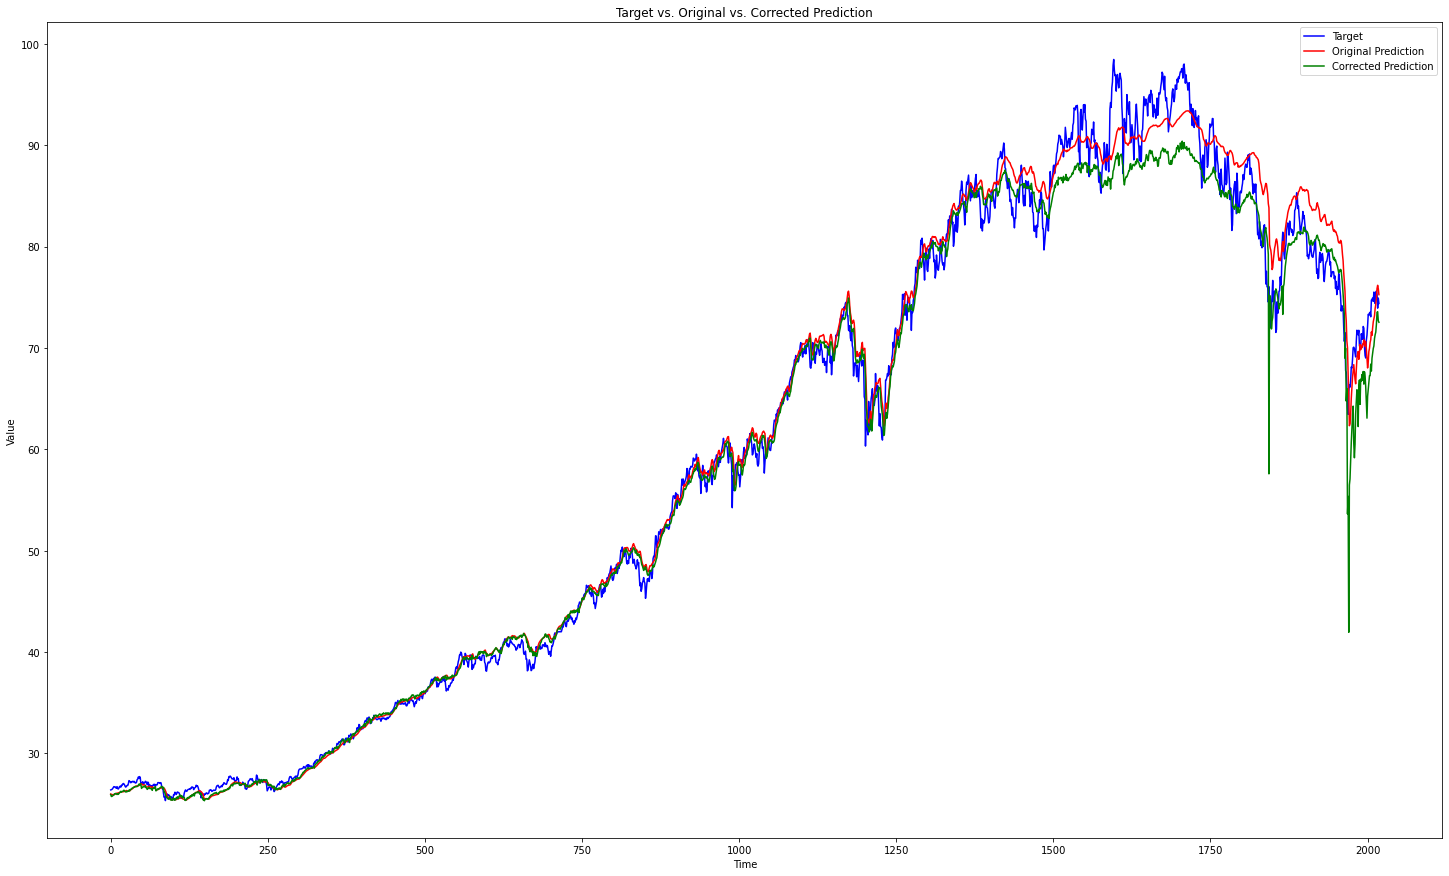

In [33]:
# plot graph of target vs original vs predicted
plt.figure(figsize=(25, 15))
plt.plot(new_df["Target"], label='Target', color='blue')
plt.plot(new_df["LSTM_Pred"], label='Original Prediction', color='red')
plt.plot(new_df["Corrected_LSTM_Pred"], label='Corrected Prediction', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Target vs. Original vs. Corrected Prediction')
plt.legend()
plt.show()

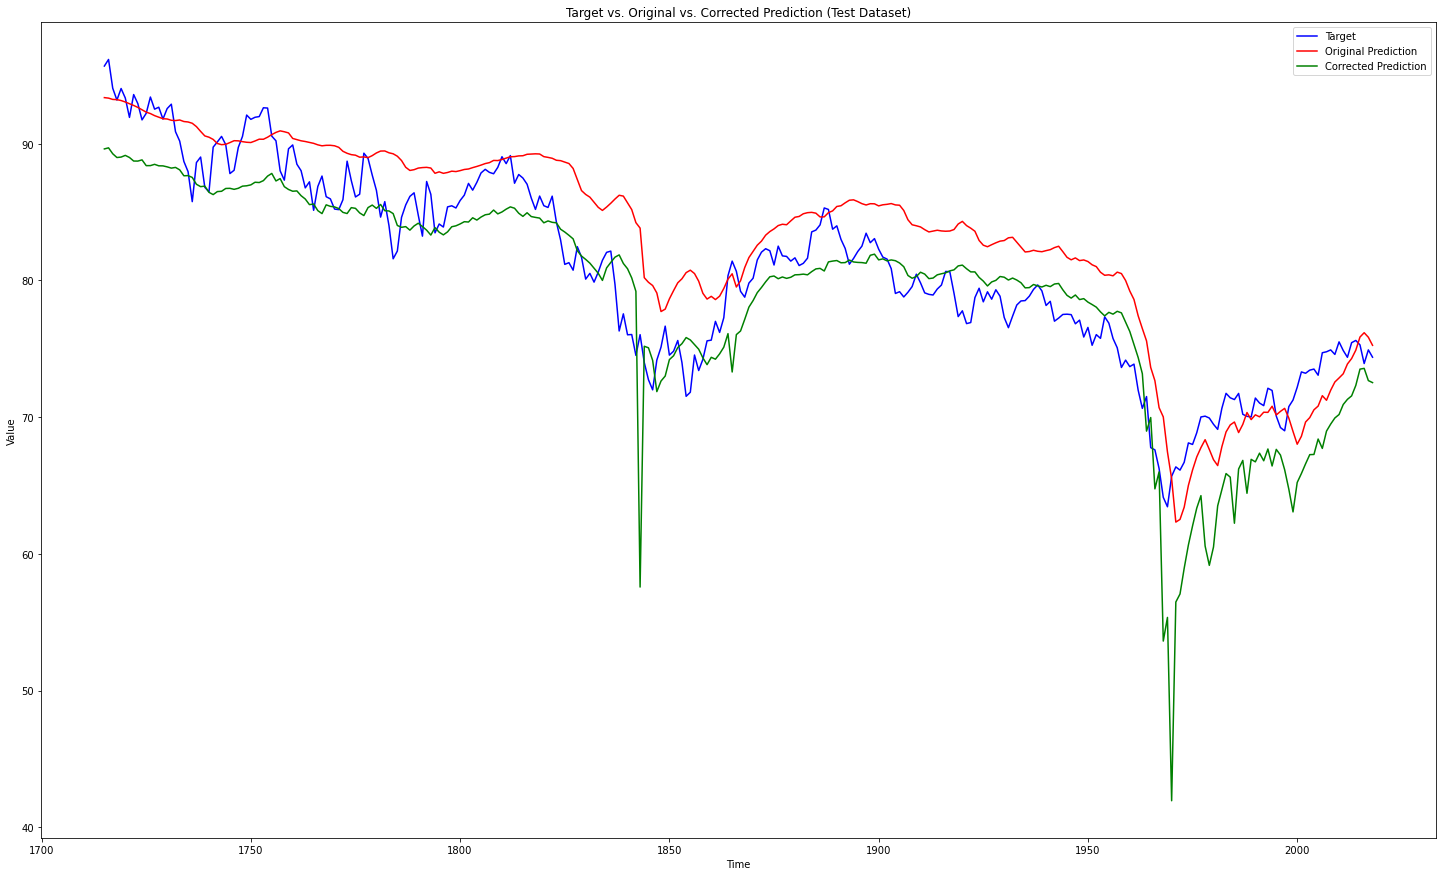

In [34]:
# only plot test dataset
plt.figure(figsize=(25, 15))
plt.plot(new_df["Target"].iloc[train_size + val_size:], label='Target', color='blue')
plt.plot(new_df["LSTM_Pred"].iloc[train_size + val_size:], label='Original Prediction', color='red')
plt.plot(new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:], label='Corrected Prediction', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Target vs. Original vs. Corrected Prediction (Test Dataset)')
plt.legend()
plt.show()

In [ ]:
# original error percent of test set
original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
corrected_error_percent_test = np.mean(np.abs(new_df["Target"].iloc[train_size + val_size:] - new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100

print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")
print(f"Corrected Error Percentage (Test Dataset): {corrected_error_percent_test:.4f}%")

Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6187%


<span style="color: yellow; font-size: 40px;">Bias correction model - array version</span>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        hidden_size2 = hidden_size // 2
        hidden_size3 = hidden_size2 // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(hidden_size3, 1)  # Final output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        return self.fc4(x)  # Output without activation since it's regression


In [ ]:
# # concat everything that has been scaled into a temporary dataframe
# temp_df = pd.DataFrame(np.concatenate([X_train_scaled, X_val_scaled, X_test_scaled], axis=0), columns=["X"])
# temp_df["y"] = np.concatenate([y_train_scaled, y_val_scaled, y_test_scaled], axis=0)

# # get reconstruction array with 10 elements each, get from temp_df
# reconstruction_error_arr = []
# for i in range(10, len(temp_df)):
#     reconstruction_error_arr.append(temp_df["X"].values[i-10:i])
    
# # append to temp_df, starting from 10th index
# temp_df = temp_df.iloc[10:]
# temp_df["Reconstruction_error_arr"] = reconstruction_error_arr

# temp_df.head()

,X,y,Reconstruction_error_arr
10,-0.105881,0.582086,"[-0.17089692906631396, -0.00851917956841292, -..."
11,-0.169245,0.405969,"[-0.00851917956841292, -0.0454752075951244, -0..."
12,-0.082765,0.363033,"[-0.0454752075951244, -0.11068696887960382, -0..."
13,-0.139474,0.412790,"[-0.11068696887960382, -0.1571496330822492, -0..."
14,-0.197267,0.516527,"[-0.1571496330822492, -0.21241881651061675, -0..."


In [ ]:
# y = temp_df["y"]
# X = temp_df["Reconstruction_error_arr"]

# # Sequential split (already scaled so don't need to scale again)
# train_size = int(0.7 * len(X))
# val_size = int(0.15 * len(X))

# X_train_raw = X[:train_size]
# y_train_raw = y[:train_size]
# X_val_raw = X[train_size:train_size + val_size]
# y_val_raw = y[train_size:train_size + val_size]
# X_test_raw = X[train_size + val_size:]
# y_test_raw = y[train_size + val_size:]

# # Convert to PyTorch tensors
# X_train = torch.tensor(np.stack(X_train_raw.values), dtype=torch.float32)
# y_train = torch.tensor(y_train_raw.values, dtype=torch.float32)
# X_val = torch.tensor(np.stack(X_val_raw.values), dtype=torch.float32)
# y_val = torch.tensor(y_val_raw.values, dtype=torch.float32)
# X_test = torch.tensor(np.stack(X_test_raw.values), dtype=torch.float32)
# y_test = torch.tensor(y_test_raw.values, dtype=torch.float32)



In [ ]:
# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
# test_dataset = TensorDataset(X_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Define model
# input_size = 10
# hidden_size1 = 64
# dropout_rate = 0.0
# learning_rate = 0.0001
# num_epochs = 500
# patience = 30

# bias_model = BiasPredictor(input_size=input_size, hidden_size1=hidden_size1, dropout_rate=dropout_rate).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

# # Train the model (don't need to save the model yet)
# best_val_loss = np.inf
# best_epoch = 0

# for epoch in range(num_epochs):
#     bias_model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         outputs = bias_model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * X_batch.size(0)
        
#     train_loss /= len(train_loader.dataset)
    
#     bias_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             outputs = bias_model(X_batch)
#             loss = criterion(outputs, y_batch)
#             val_loss += loss.item() * X_batch.size(0)
        
#     val_loss /= len(val_loader.dataset)
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch
#     elif epoch - best_epoch >= patience:
#         print(f"Stopping early at epoch {epoch}")
#         break
    
#     print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        

        

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduct

Epoch 0, Train Loss: 0.9099, Val Loss: 5.9060
Epoch 1, Train Loss: 0.8952, Val Loss: 5.9502
Epoch 2, Train Loss: 0.8848, Val Loss: 6.0254
Epoch 3, Train Loss: 0.8763, Val Loss: 6.1445
Epoch 4, Train Loss: 0.8662, Val Loss: 6.4579
Epoch 5, Train Loss: 0.8535, Val Loss: 7.1189
Epoch 6, Train Loss: 0.8428, Val Loss: 7.9325
Epoch 7, Train Loss: 0.8375, Val Loss: 8.2106
Epoch 8, Train Loss: 0.8342, Val Loss: 8.4753
Epoch 9, Train Loss: 0.8342, Val Loss: 8.3110
Epoch 10, Train Loss: 0.8321, Val Loss: 8.3804
Epoch 11, Train Loss: 0.8311, Val Loss: 8.1740
Epoch 12, Train Loss: 0.8313, Val Loss: 8.0241
Epoch 13, Train Loss: 0.8316, Val Loss: 7.8178
Epoch 14, Train Loss: 0.8310, Val Loss: 7.8435
Epoch 15, Train Loss: 0.8298, Val Loss: 7.7363
Epoch 16, Train Loss: 0.8302, Val Loss: 7.7193
Epoch 17, Train Loss: 0.8300, Val Loss: 7.5720
Epoch 18, Train Loss: 0.8294, Val Loss: 7.6434
Epoch 19, Train Loss: 0.8299, Val Loss: 7.5778
Epoch 20, Train Loss: 0.8304, Val Loss: 7.5486
Epoch 21, Train Loss: 0

In [ ]:
# # Get predictions on entire set
# combined_X = torch.cat((X_train, X_val, X_test), dim=0)
# combined_y = torch.cat((y_train, y_val, y_test), dim=0)
# # convert x_scaled to tensor
# X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
# bias_model.eval()
# with torch.no_grad():
#     y_pred = bias_model(X_scaled_tensor.to(device)).cpu().numpy()

C:\Users\ROG\AppData\Local\Temp/ipykernel_29008/2623475989.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


In [ ]:
# # Unscale outputs
# outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

In [ ]:
# if new_df.shape[0] != len(outputs_unscaled):
#     new_df = new_df.iloc[10:]
# new_df["Bias_Pred"] = outputs_unscaled
# new_df["Corrected_LSTM_Pred"] = new_df["LSTM_Pred"] + new_df["Bias_Pred"]

In [ ]:
# original_error_percent = np.mean(np.abs(new_df["Bias"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100
# corrected_error_percent = np.mean(np.abs(new_df["Target"] - new_df["Corrected_LSTM_Pred"]) / (np.abs(new_df["Target"]) + 1e-8)) * 100

# print(f"Original Error Percentage (entire dataset): {original_error_percent:.4f}%")
# print(f"Corrected Error Percentage (entire dataset): {corrected_error_percent:.4f}%")

Original Error Percentage (entire dataset): 2.1527%
Corrected Error Percentage (entire dataset): 2.2123%


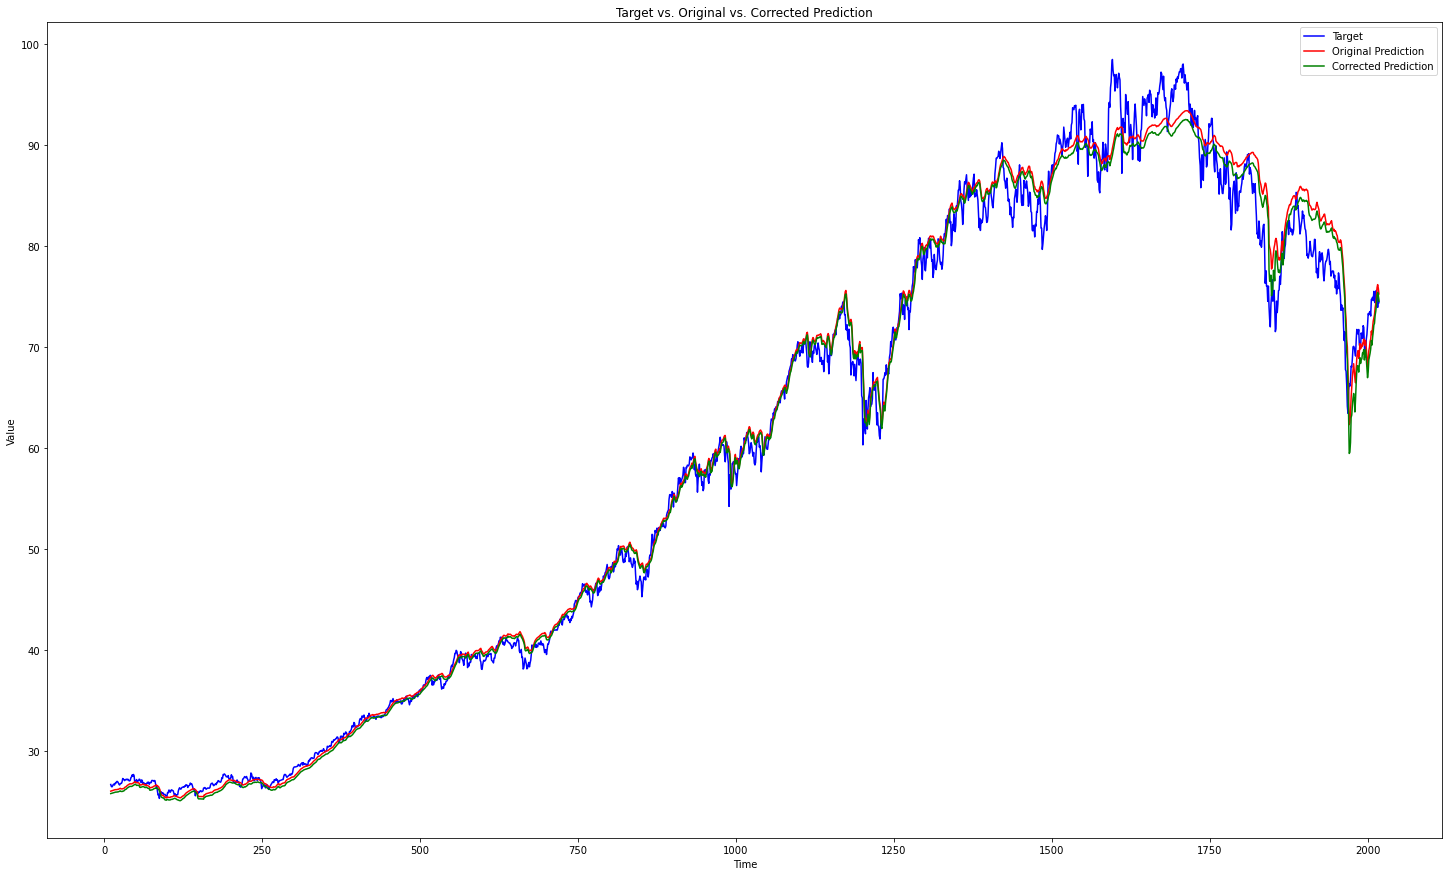

In [ ]:
# # plot graph of target vs original vs predicted
# plt.figure(figsize=(25, 15))
# plt.plot(new_df["Target"], label='Target', color='blue')
# plt.plot(new_df["LSTM_Pred"], label='Original Prediction', color='red')
# plt.plot(new_df["Corrected_LSTM_Pred"], label='Corrected Prediction', color='green')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Target vs. Original vs. Corrected Prediction')
# plt.legend()
# plt.show()

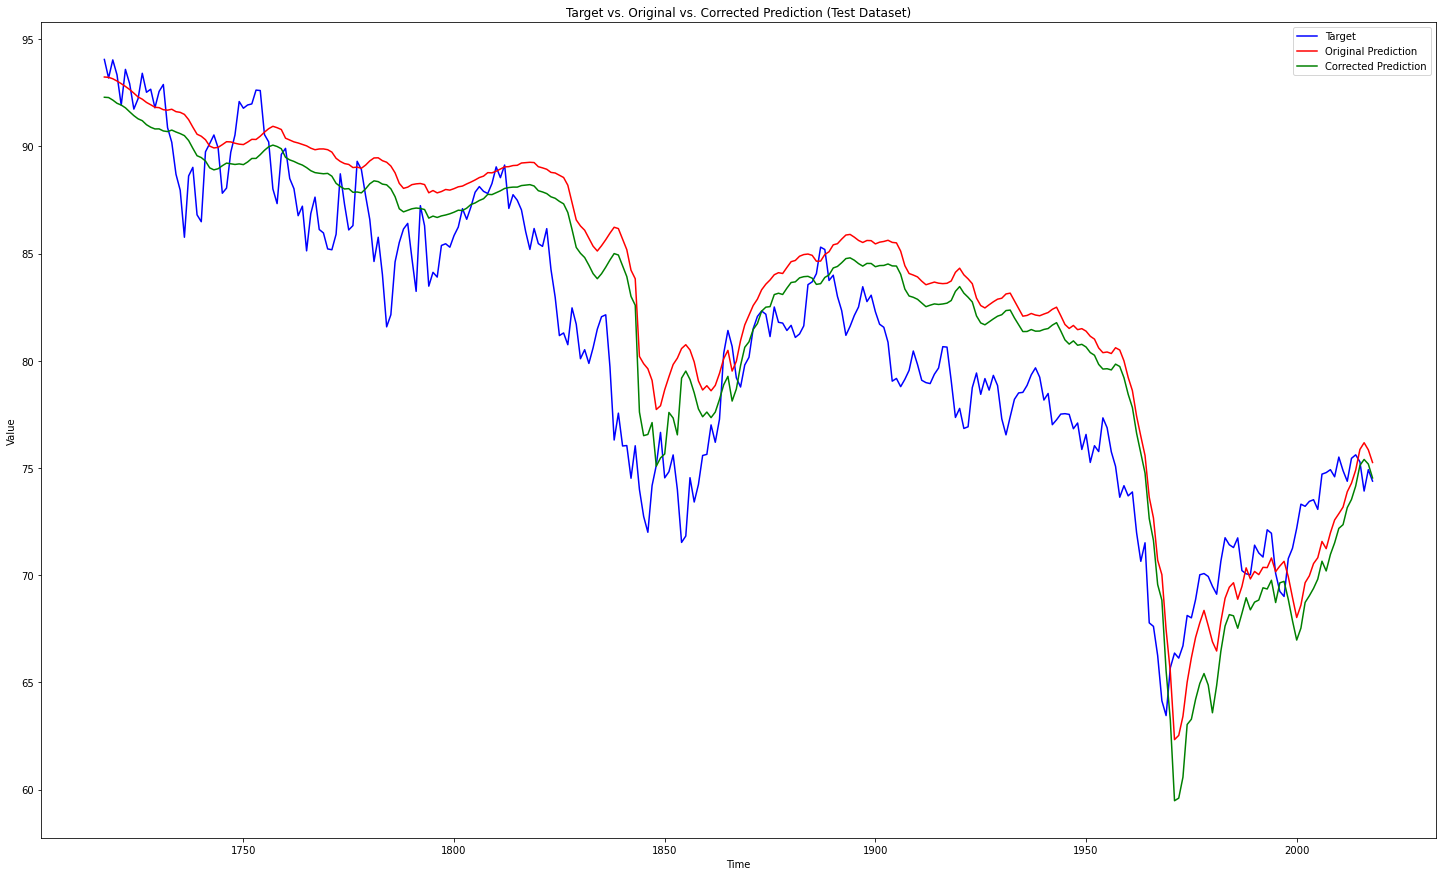

In [ ]:
# # only plot test dataset
# plt.figure(figsize=(25, 15))
# plt.plot(new_df["Target"].iloc[train_size + val_size:], label='Target', color='blue')
# plt.plot(new_df["LSTM_Pred"].iloc[train_size + val_size:], label='Original Prediction', color='red')
# plt.plot(new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:], label='Corrected Prediction', color='green')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Target vs. Original vs. Corrected Prediction (Test Dataset)')
# plt.legend()
# plt.show()

In [ ]:
# # original error percent of test set
# original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
# corrected_error_percent_test = np.mean(np.abs(new_df["Target"].iloc[train_size + val_size:] - new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100

# print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")
# print(f"Corrected Error Percentage (Test Dataset): {corrected_error_percent_test:.4f}%")

Original Error Percentage (Test Dataset): 4.0490%
Corrected Error Percentage (Test Dataset): 3.5206%


<span style="color: yellow; font-size: 40px;">Bias correction model - array version with feature importance</span>

In [ ]:
# import shap

# # Define a custom wrapper for the PyTorch model
# class ModelWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, data):
#         self.model.eval()
#         with torch.no_grad():
#             data = torch.tensor(data, dtype=torch.float32).to(device)
#             return self.model(data).cpu().numpy()

# # Create SHAP explainer
# wrapped_model = ModelWrapper(bias_model)
# explainer = shap.Explainer(wrapped_model, X_train.to(device).cpu().numpy())

# # Get SHAP values
# shap_values = explainer(X_test.to(device).cpu().numpy())

# # Convert to numpy
# shap_values_array = shap_values.values

# # Average SHAP values across all test samples
# feature_importance = np.mean(np.abs(shap_values_array), axis=0)

# # Display results
# print("SHAP Feature Importance:", feature_importance)

Exact explainer: 303it [00:11,  5.30it/s]                         

SHAP Feature Importance: [0.19307269 0.03799424 0.01970377 0.11102386 0.05051588 0.09308319
 0.02926397 0.07811715 0.11694003 0.07107876]


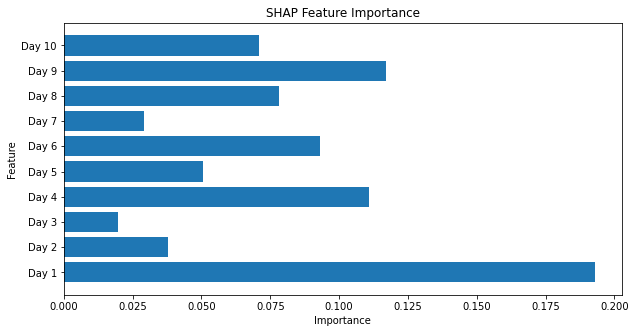

Day 1 SHAP Value: 0.1931
Day 2 SHAP Value: 0.0380
Day 3 SHAP Value: 0.0197
Day 4 SHAP Value: 0.1110
Day 5 SHAP Value: 0.0505
Day 6 SHAP Value: 0.0931
Day 7 SHAP Value: 0.0293
Day 8 SHAP Value: 0.0781
Day 9 SHAP Value: 0.1169
Day 10 SHAP Value: 0.0711


In [ ]:
# num_features = len(feature_importance)
# feature_labels = [f"Day {i+1}" for i in range(num_features)]

# # Plot bar chart of SHAP values
# plt.figure(figsize=(10, 5))
# plt.barh(feature_labels, feature_importance)
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('SHAP Feature Importance')
# plt.show()

# for i in range(num_features):
#     print(f"Day {i+1} SHAP Value: {feature_importance[i]:.4f}")